In [1]:
# Script to analyse the Bfactor distribution from a range of perturbed structures and compare them to 
# atomic model and pseudo-atomic model

import numpy as np
import matplotlib.pyplot as plt
from locscale.include.emmer.pdb.pdb_utils import get_bfactors
import os


In [3]:
high_resolution_emmap_filename = "EMD_20521_unsharpened_fullmap.mrc"
high_resolution_pdb_filename = "PDB_6pxm_unrefined_shifted_servalcat_refined.pdb"
low_resolution_emdb_filename = "EMD_4141_unsharpened_fullmap.mrc"
low_resolution_pdb_filename = "PDB_5m1s_unrefined_shifted_servalcat_refined.pdb"


parent_folder_high_res_results = f"./num_atoms_study_{high_resolution_emmap_filename.split('.')[0]}"
parent_folder_low_res_results = f"./num_atoms_study_{low_resolution_emdb_filename.split('.')[0]}"

emmap_path_high_res = os.path.join(parent_folder_high_res_results, f"{high_resolution_emmap_filename}")
emmap_path_low_res = os.path.join(parent_folder_low_res_results, f"{low_resolution_emdb_filename}")

atomic_model_results_high_res = os.path.join(parent_folder_high_res_results, "atomic_model_refinement")
#pseudo_atomic_model_results_high_res = os.path.join(parent_folder_high_res_results, "using_pseudo_atomic_model")

atomic_model_results_low_res = os.path.join(parent_folder_low_res_results, "atomic_model_refinement")
#pseudo_atomic_model_results_low_res = os.path.join(parent_folder_low_res_results, "pseudomodel_refinement")

refined_atomic_model_path_high_res = os.path.join(atomic_model_results_high_res, high_resolution_pdb_filename.replace(".pdb", "_servalcat_refined.pdb"))
#refined_pseudo_atomic_model_path_high_res = os.path.join(pseudo_atomic_model_results_high_res, "emd_20521_FDR_confidence_final_gradient_pseudomodel_uniform_biso_proper_element_composition.pdb")

refined_atomic_model_path_low_res = os.path.join(atomic_model_results_low_res, low_resolution_pdb_filename.replace(".pdb", "_servalcat_refined.pdb"))
#refined_pseudo_atomic_model_path_low_res = os.path.join(pseudo_atomic_model_results_low_res, "emd_4141_FDR_confidence_final_gradient_pseudomodel_proper_element_composition_proper_element_composition.pdb")
assert os.path.exists(refined_atomic_model_path_high_res), f"File {refined_atomic_model_path_high_res} does not exist"
assert os.path.exists(refined_atomic_model_path_low_res), f"File {refined_atomic_model_path_low_res} does not exist"

In [4]:
num_atoms_fractions = [0.6, 0.8, 1, 1.2, 1.4]
num_atoms_fracs = [int(i*100) for i in num_atoms_fractions]

perturbed_structures_high_res = {}
perturbed_structures_low_res = {}

for count, i in enumerate(num_atoms_fracs):
    perturbed_structure_folder_high_res = os.path.join(parent_folder_high_res_results, "num_atoms_frac_{}".format(i))
    perturbed_structure_folder_low_res = os.path.join(parent_folder_low_res_results, "num_atoms_frac_{}".format(i))

    perturbed_refined_path_high_res = os.path.join(perturbed_structure_folder_high_res, f"adjusted_pdb_frac_{i}_proper_element_composition.pdb")
    perturbed_refined_path_low_res = os.path.join(perturbed_structure_folder_low_res, f"adjusted_pdb_frac_{i}_proper_element_composition.pdb")

    assert os.path.exists(perturbed_refined_path_high_res), "Path does not exist: {}".format(perturbed_refined_path_high_res)
    assert os.path.exists(perturbed_refined_path_low_res), "Path does not exist: {}".format(perturbed_refined_path_low_res)
    perturb_rmsd = num_atoms_fractions[count]
    perturbed_structures_high_res[perturb_rmsd] = perturbed_refined_path_high_res
    perturbed_structures_low_res[perturb_rmsd] = perturbed_refined_path_low_res




In [5]:
import gemmi
def get_coordinates_avg_bfactors_pdb(st, atomic_positions, window_size, ns):
    coordinates_bfactors_dict = {}
    for atom_pos in atomic_positions: 
        gemmi_pos = gemmi.Position(atom_pos[0], atom_pos[1], atom_pos[2])
        neighbors = ns.find_atoms(gemmi_pos, '\0', window_size)
        ADP_neighbors = [n.to_cra(st[0]).atom.b_iso for n in neighbors]
        avg_bfactor = np.mean(ADP_neighbors)
        coordinates_bfactors_dict[tuple(atom_pos)] = avg_bfactor
    
    return coordinates_bfactors_dict

def get_coordinates_1(st):
    coordinates = []
    for cra in st[0].all():
        coordinates.append(cra.atom.pos.tolist())
    return coordinates



In [6]:
import random

# Get coordinates of high res atomic model and low res atomic model
st_high_res = gemmi.read_structure(refined_atomic_model_path_high_res)
st_low_res = gemmi.read_structure(refined_atomic_model_path_low_res)

atomic_coordinates_high_res = get_coordinates_1(st_high_res)
atomic_coordinates_low_res = get_coordinates_1(st_low_res)

sample_coordinates_high_res = random.sample(atomic_coordinates_high_res, 1000)
sample_coordinates_low_res = random.sample(atomic_coordinates_low_res, 1000)


In [7]:
# For each perturbed structure get the average Bfactor of sample atoms within a window of 25A  
from tqdm import tqdm
perturbed_average_bfactors_high_res = {}
perturbed_average_bfactors_low_res = {}

# Combine perturbed structures , atomic model and pseudo-atomic model into one dictionary for each resolution
perturbed_structures_high_res["atomic_model"] = refined_atomic_model_path_high_res
#perturbed_structures_high_res["pseudo_atomic_model"] = refined_pseudo_atomic_model_path_high_res

perturbed_structures_low_res["atomic_model"] = refined_atomic_model_path_low_res
#perturbed_structures_low_res["pseudo_atomic_model"] = refined_pseudo_atomic_model_path_low_res

# Check if all paths exist
for key, pdb_path in perturbed_structures_high_res.items():
    assert os.path.exists(pdb_path), f"{pdb_path} does not exist"

for key, pdb_path in perturbed_structures_low_res.items():
    assert os.path.exists(pdb_path), f"{pdb_path} does not exist"
    
# Get average Bfactors for each perturbed structure
for key, pdb_path in tqdm(perturbed_structures_high_res.items()):
    st = gemmi.read_structure(pdb_path)
    ns = gemmi.NeighborSearch(st[0], st.cell, 25).populate()
    perturbed_average_bfactors_high_res[key] = list(get_coordinates_avg_bfactors_pdb(\
                                            st, sample_coordinates_high_res, 25, ns).values())

for key, pdb_path in tqdm(perturbed_structures_low_res.items()):
    st = gemmi.read_structure(pdb_path)
    ns = gemmi.NeighborSearch(st[0], st.cell, 25).populate()
    perturbed_average_bfactors_low_res[key] = list(get_coordinates_avg_bfactors_pdb(\
                                            st, sample_coordinates_low_res, 25, ns).values())






100%|██████████| 6/6 [00:43<00:00,  7.31s/it]


[Text(1, 0, '0.6'),
 Text(2, 0, '0.8'),
 Text(3, 0, '1'),
 Text(4, 0, '1.2'),
 Text(5, 0, '1.4'),
 Text(6, 0, 'atomic_model')]

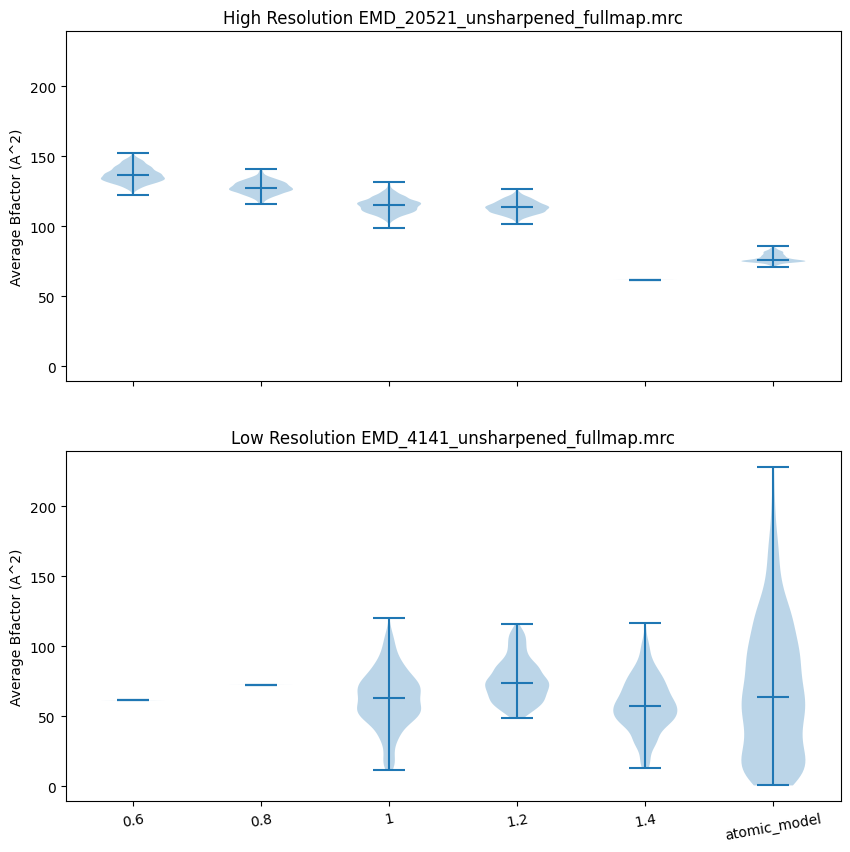

In [8]:
# Plot the distribution of average Bfactors for each perturbed structure as violin plots
# in two subplots. Top and bottom subplots are for high and low resolution respectively. 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)

ax1.violinplot(perturbed_average_bfactors_high_res.values(), showmeans=False, showmedians=True)
ax1.set_title("High Resolution {}".format(high_resolution_emmap_filename))
ax1.set_ylabel("Average Bfactor (A^2)")
ax1.set_xticks(range(1, len(perturbed_average_bfactors_high_res.keys())+1))
ax1.set_xticklabels(perturbed_average_bfactors_high_res.keys(), rotation=10)

ax2.violinplot(perturbed_average_bfactors_low_res.values(), showmeans=False, showmedians=True)
ax2.set_title("Low Resolution {}".format(low_resolution_emdb_filename))
ax2.set_ylabel("Average Bfactor (A^2)")
ax2.set_xticks(range(1, len(perturbed_average_bfactors_low_res.keys())+1))
ax2.set_xticklabels(perturbed_average_bfactors_low_res.keys(), rotation=10)


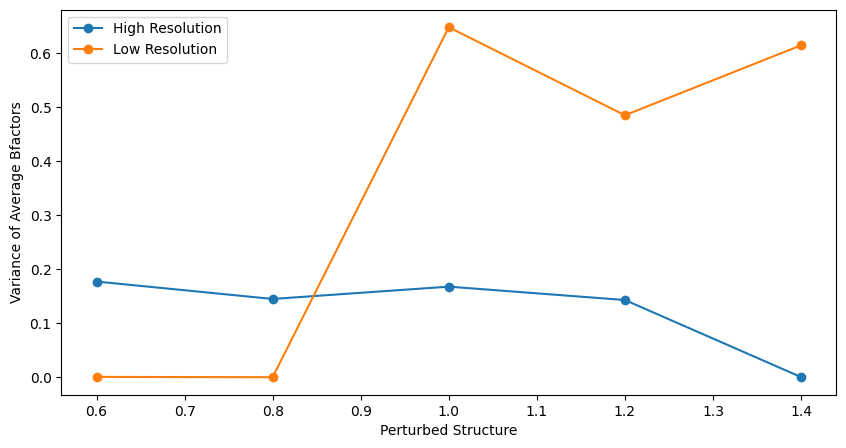

In [10]:
# Do a variation analysis of the average Bfactors of the perturbed structures 
# and the atomic model and pseudo-atomic model.

variation_analysis_high_res = {}
variation_analysis_low_res = {}

for key, avg_bfactors in perturbed_average_bfactors_high_res.items():
    if key in ["atomic_model", "pseudo_atomic_model"]:
        continue
    standard_error = np.std(avg_bfactors)/np.sqrt(len(avg_bfactors))
    variation_analysis_high_res[key] = standard_error

for key, avg_bfactors in perturbed_average_bfactors_low_res.items():
    if key in ["atomic_model", "pseudo_atomic_model"]:
        continue
    standard_error = np.std(avg_bfactors)/np.sqrt(len(avg_bfactors))
    variation_analysis_low_res[key] = standard_error

# Plot the variation analysis as a bar plot for high and low resolution in a single subplot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(variation_analysis_high_res.keys(), variation_analysis_high_res.values(), label="High Resolution", marker="o")
ax.plot(variation_analysis_low_res.keys(), variation_analysis_low_res.values(), label="Low Resolution", marker="o")
ax.set_ylabel("Variance of Average Bfactors")
ax.set_xlabel("Perturbed Structure")
ax.legend()






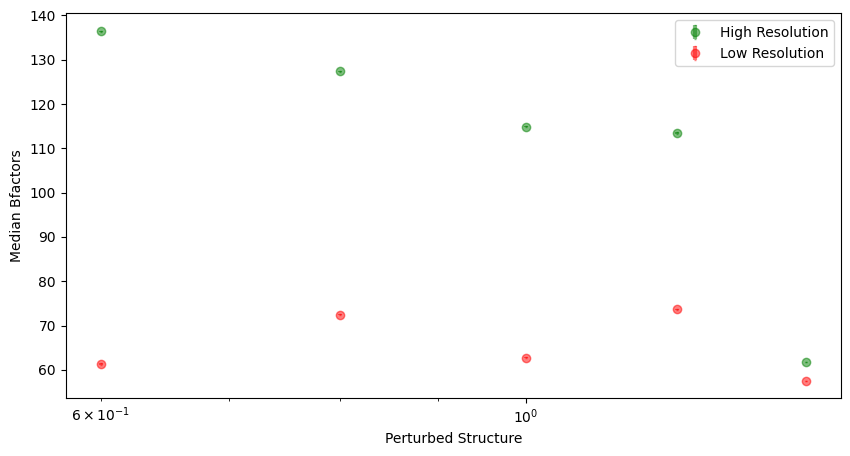

In [11]:
# Plot the change in median Bfactors for each perturbed structure for high and low resolution

median_bfactors_high_res = {}
median_bfactors_low_res = {}

for key, avg_bfactors in perturbed_average_bfactors_high_res.items():
    if key in ["atomic_model", "pseudo_atomic_model"]:
        continue
    median_bfactors_high_res[key] = np.median(avg_bfactors)

for key, avg_bfactors in perturbed_average_bfactors_low_res.items():
    if key in ["atomic_model", "pseudo_atomic_model"]:
        continue
    median_bfactors_low_res[key] = np.median(avg_bfactors)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

#ax.plot(median_bfactors_high_res.keys(), median_bfactors_high_res.values(), label="High Resolution", marker="o")
# plot the error bars to show the standard deviation of the median Bfactors
ax.errorbar(median_bfactors_high_res.keys(), median_bfactors_high_res.values(), yerr=list(variation_analysis_high_res.values()), \
            fmt='o', color='green',  elinewidth=3, capsize=1, alpha=0.5, label="High Resolution")
#ax.plot(median_bfactors_low_res.keys(), median_bfactors_low_res.values(), label="Low Resolution", marker="o")
ax.errorbar(median_bfactors_low_res.keys(), median_bfactors_low_res.values(), yerr=list(variation_analysis_high_res.values()), \
            fmt='o', color='red',  elinewidth=3, capsize=1, alpha=0.5, label="Low Resolution")
# Set X axis scale to log
ax.set_xscale("log")
ax.set_ylabel("Median Bfactors")
ax.set_xlabel("Perturbed Structure")
ax.legend()




In [12]:
# Plot the distribution of average Bfactors for each perturbed structure as box plots
# in the same subplot.


# rearrange the avg bfactor high res dictionary such that the first key is the atomic model followed by perturbed structures and finally the pseudo-atomic model
perturbed_structures_high_res_ordered = {}

perturbed_structures_high_res_ordered["atomic_model"] = perturbed_average_bfactors_high_res["atomic_model"]
for key in perturbed_average_bfactors_high_res.keys():
    if key in ["atomic_model", "pseudo_atomic_model"]:
        continue
    perturbed_structures_high_res_ordered[key] = perturbed_average_bfactors_high_res[key]

#perturbed_structures_high_res_ordered["pseudo_atomic_model"] = perturbed_average_bfactors_high_res["pseudo_atomic_model"]

perturbed_structures_low_res_ordered = {}

perturbed_structures_low_res_ordered["atomic_model"] = perturbed_average_bfactors_low_res["atomic_model"]
for key in perturbed_average_bfactors_low_res.keys():
    if key in ["atomic_model", "pseudo_atomic_model"]:
        continue
    perturbed_structures_low_res_ordered[key] = perturbed_average_bfactors_low_res[key]

#perturbed_structures_low_res_ordered["pseudo_atomic_model"] = perturbed_average_bfactors_low_res["pseudo_atomic_model"]





[Text(1, 0, 'atomic_model'),
 Text(2, 0, '0.6'),
 Text(3, 0, '0.8'),
 Text(4, 0, '1'),
 Text(5, 0, '1.2'),
 Text(6, 0, '1.4')]

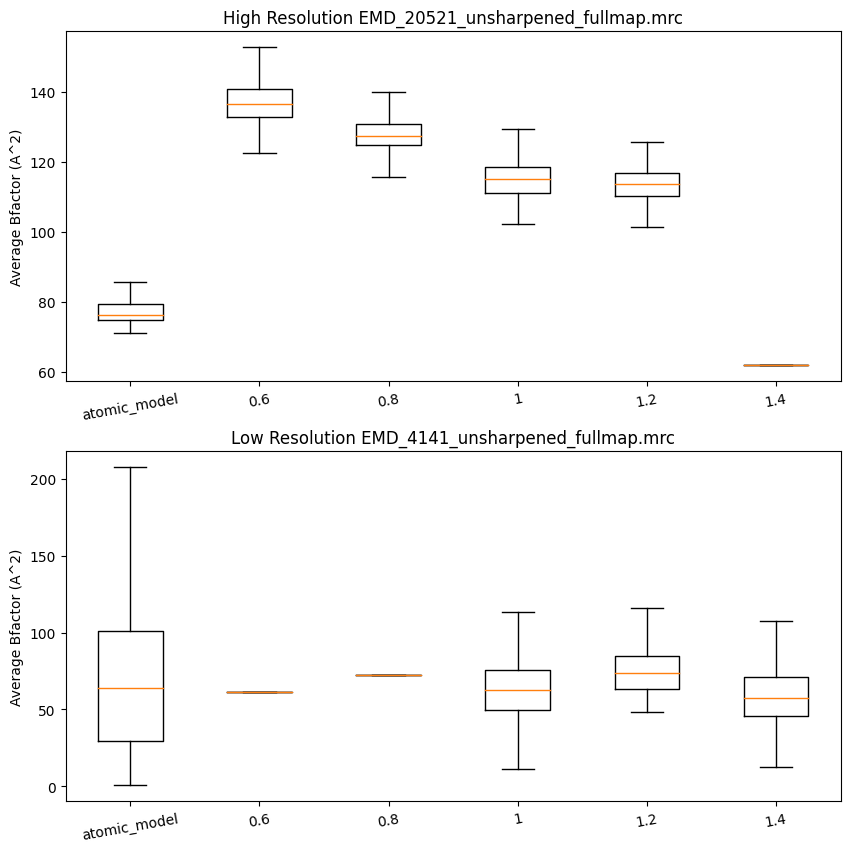

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.boxplot(perturbed_structures_high_res_ordered.values(), showfliers=False)
ax1.set_title("High Resolution {}".format(high_resolution_emmap_filename))
ax1.set_ylabel("Average Bfactor (A^2)")
ax1.set_xticks(range(1, len(perturbed_structures_high_res_ordered.keys())+1))
ax1.set_xticklabels(perturbed_structures_high_res_ordered.keys(), rotation=10)

ax2.boxplot(perturbed_structures_low_res_ordered.values(), showfliers=False)
ax2.set_title("Low Resolution {}".format(low_resolution_emdb_filename))
ax2.set_ylabel("Average Bfactor (A^2)")
ax2.set_xticks(range(1, len(perturbed_structures_low_res_ordered.keys())+1))
ax2.set_xticklabels(perturbed_structures_low_res_ordered.keys(), rotation=10)



In [14]:
# Find out the average coordinate error between the atomic model and the pseudo-atomic model
# for the high resolution structure

def get_average_coordinate_error(atomic_model, pseudo_atomic_model):
    """Get the average coordinate error between the atomic model and the pseudo-atomic model"""
    coordinate_error = []
    # loop over each atom in the pseudo-atomic model and find the nearest atom in the atomic model
    # coordinate error is the distance between the two atoms
    st_pseudo = gemmi.read_structure(pseudo_atomic_model)
    st_atomic = gemmi.read_structure(atomic_model)

    ns_pseudo = gemmi.NeighborSearch(st_pseudo[0], st_pseudo.cell, 10).populate()
    ns_atomic = gemmi.NeighborSearch(st_atomic[0], st_atomic.cell, 10).populate()

    for cra_pseudo in st_pseudo[0].all():
        atom_pseudo = cra_pseudo.atom
        nearest_search = ns_atomic.find_nearest_atom(atom_pseudo.pos)
        if nearest_search is None:
            continue
        atom_atomic = nearest_search.to_cra(st_atomic[0]).atom
        coordinate_error.append(atom_pseudo.pos.dist(atom_atomic.pos))
    
    coordinate_error = np.array(coordinate_error)
    return coordinate_error